<a href="https://colab.research.google.com/github/andigu/crbm/blob/main/RBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf 
import tensorflow_probability as tfp
import numpy as np 
from sklearn.neural_network import BernoulliRBM
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
class RBM(tf.keras.models.Model):
    def __init__(self, nv=2, nh=20, **kwargs):
        super(RBM, self).__init__(**kwargs)
        self.nv, self.nh = nv, nh
        self.W = tf.Variable(tf.random.normal((nv, nh)), trainable=True)
        self.bv = tf.Variable(tf.random.normal((nv, 1)), trainable=True) 
        self.bh = tf.Variable(tf.random.normal((nh, 1)), trainable=True)
        
    def bernoulli(self, p):
        return tf.nn.relu(tf.sign(p - tf.random.uniform(p.shape)))
    
    def energy(self, v):
        b_term = tf.squeeze(tf.matmul(v, self.bv))
        linear_tranform = tf.matmul(v, self.W) + tf.squeeze(self.bh)
        h_term = tf.reduce_sum(tf.math.log(tf.exp(linear_tranform) + 1), axis=1) 
        return tf.reduce_mean(-h_term -b_term)
    
    def sample_h(self, v):
        ph_given_v = tf.sigmoid(tf.matmul(v, self.W) + tf.squeeze(self.bh))
        return self.bernoulli(ph_given_v)
    
    def sample_v(self, h):
        pv_given_h = tf.sigmoid(tf.matmul(h, tf.transpose(self.W)) + tf.squeeze(self.bv))
        return self.bernoulli(pv_given_h)
    
    def gibbs_step(self, i, vk):
        hk = self.sample_h(vk)
        vk = self.sample_v(hk)
        return i+1, vk
    
    def gibbs_sample(self, n_samples, n_steps=3):
        init = tf.cast(tf.random.uniform(shape=(n_samples, self.nv), maxval=1) <= 0.5, tf.float32)
        _, x_samples = tf.while_loop(cond=lambda i, _: i <= n_steps, body = rbm.gibbs_step, 
                              loop_vars = [0, init], parallel_iterations=1,)
        return x_samples
    
    def call(self, x):
        x_samples = self.gibbs_sample(100*len(x))
        self.add_loss(self.energy(x) - self.energy(tf.stop_gradient(x_samples)))

In [3]:
def to_freq(data):
    data = np.packbits(data.astype(np.int), axis=1, bitorder='little').flatten()
    vals, freq = np.unique(data, return_counts=True)
    return freq/freq.sum()

In [4]:
from tqdm import trange
data_vals = []
weights = np.random.normal(size=4)
probs = np.abs(np.random.normal(size=4))
probs = probs/probs.sum()
for _ in trange(1000):
    tmp = np.random.choice(4, p=probs, size=5000)
    options = np.array([[0,0],[0,1],[1,0],[1,1]])
    X = options[tmp].astype(np.float32)
    data_vals.append(weights @ (to_freq(X)))

100%|██████████| 1000/1000 [00:00<00:00, 1522.73it/s]


In [5]:
X.shape

(5000, 2)

In [6]:
rbm = RBM(nh=20)
rbm_vals = []
rbm.compile(optimizer=tf.optimizers.SGD(0.1))
callbacks=[
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20),
    tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='loss'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=5)
]
rbm.fit(X, batch_size=10, verbose=2, epochs=200, callbacks=callbacks)
rbm.load_weights('model.h5')
to_freq(rbm.gibbs_sample(100000, n_steps=3).numpy()), to_freq(X)
for _ in trange(100):
    rbm_vals.append(weights @ (to_freq(rbm.gibbs_sample(100000).numpy())))

Epoch 1/200
500/500 - 1s - loss: 0.0129
Epoch 2/200
500/500 - 1s - loss: 0.0137
Epoch 3/200
500/500 - 1s - loss: 0.0232
Epoch 4/200
500/500 - 1s - loss: 0.0185
Epoch 5/200
500/500 - 1s - loss: 0.0193
Epoch 6/200
500/500 - 1s - loss: 0.0185
Epoch 7/200
500/500 - 1s - loss: 0.0088
Epoch 8/200
500/500 - 1s - loss: 0.0045
Epoch 9/200
500/500 - 1s - loss: 0.0046
Epoch 10/200
500/500 - 1s - loss: 0.0018
Epoch 11/200
500/500 - 1s - loss: 0.0022
Epoch 12/200
500/500 - 1s - loss: 0.0035
Epoch 13/200
500/500 - 1s - loss: 0.0018
Epoch 14/200
500/500 - 1s - loss: 0.0034
Epoch 15/200
500/500 - 1s - loss: 0.0014
Epoch 16/200
500/500 - 1s - loss: 0.0034
Epoch 17/200
500/500 - 1s - loss: 0.0027
Epoch 18/200
500/500 - 1s - loss: 5.7491e-04
Epoch 19/200
500/500 - 1s - loss: 0.0021
Epoch 20/200
500/500 - 1s - loss: 0.0014
Epoch 21/200
500/500 - 1s - loss: 0.0019
Epoch 22/200
500/500 - 1s - loss: 0.0027
Epoch 23/200
500/500 - 1s - loss: 0.0017
Epoch 24/200
500/500 - 1s - loss: 0.0014
Epoch 25/200
500/500 

100%|██████████| 100/100 [00:13<00:00,  7.17it/s]


In [7]:
np.round(to_freq(rbm.gibbs_sample(100000).numpy()),3), np.round(to_freq(X),3)

(array([0.326, 0.147, 0.162, 0.365]), array([0.325, 0.146, 0.164, 0.366]))

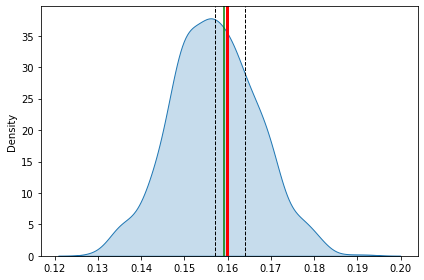

In [8]:
sns.kdeplot(data_vals, fill=True)
plt.axvline(np.percentile(np.array(rbm_vals), 5), c='black', ls='--', lw=1)
plt.axvline(np.percentile(np.array(rbm_vals), 95), c='black', ls='--', lw=1)
plt.axvline(np.percentile(np.array(rbm_vals), 50), c='red', lw=3)
plt.axvline(weights@to_freq(X), c='green')
plt.tight_layout()